  # Survival Prediction of Patients with Heart Disease using Machine Learning classification Techniques 
    
 ## Dataset Link 
 
 https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
 
 ## Dataset Description
 
 Feature | Explanation | Measurement	| Range
------------- | ------------- |------------- | -------------
Age	|Age of the patient	|Years |	[40,..., 95]
Anaemia	|Decrease of red <br> blood cells or hemoglobin |	Boolean|	0, 1
High blood pressure |	If a patient has hypertension |	Boolean	 |0, 1
Creatinine phosphokinase<br>(CPK) |	Level of the CPK enzyme <br>in the blood |	mcg/L|	[23,..., 7861]
Diabetes|	If the patient has diabetes |	Boolean	| 0, 1
Ejection fraction|	Percentage of blood leaving<br>the heart at each contraction|Percentage	|	[14,..., 80]
Sex	| Woman or man |	Binary|	0, 1
Platelets|	Platelets in the blood|	kiloplatelets/mL|	[25.01,..., 850.00]
Serum creatinine|	Level of creatinine in the blood|	mg/dL|	[0.50,..., 9.40]
Serum sodium|	Level of sodium in the blood|	mEq/L|	[114,..., 148]
Smoking|	If the patient smokes|	Boolean	|0, 1
Time|	Follow-up period|	Days|	[4,...,285]
DEATH EVENT<br>(TARGET)|	If the patient died during the follow-up period|	Boolean|	0, 1



### Required Libraries and Utilities

In [1]:
# Import the required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from scipy.stats import randint 

from imblearn.over_sampling import SMOTE
from collections import Counter

from xgboost import XGBClassifier

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj

init_notebook_mode(connected=True)
import plotly.figure_factory as ff

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier

# To display all the columns
pd.options.display.max_columns = None

# To display all the rows
pd.options.display.max_rows = None

# To map Empty Strings or numpy.inf as Na Values
pd.options.mode.use_inf_as_na = True

pd.options.display.expand_frame_repr =  False

%matplotlib inline

# Set Style
sns.set(style = "whitegrid")

### Utility Functions

In [2]:
# Custom Function to add data labels in the graph

def add_data_labels(ax, spacing = 5):

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}%".format(y_value)

        # Create annotation
        plt.annotate(
            label,                        # Use `label` as label
            (x_value, y_value),           # Place label at end of the bar
            xytext = (0, space),          # Vertically shift label by `space`
            textcoords = "offset points", # Interpret `xytext` as offset in points
            ha = 'center',                # Horizontally center label
            va = va)                      # Vertically align label differently for positive and negative values.

### Import Data

In [3]:
heart_faliure_data = pd.read_csv('heart_failure_clinical_records_dataset.csv', low_memory = False, skipinitialspace = True)

heart_faliure_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


<a id='Class_imbalance'></a>
## Class imbalance <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

One thing to take into account is the possible class imbalance.<br>

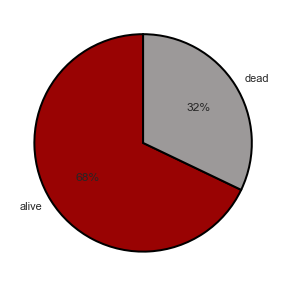

In [4]:
plt.figure(figsize=(5, 5))
plt.pie(heart_faliure_data["DEATH_EVENT"].value_counts(),
        labels = ["alive", "dead"],
        colors = ["#990303", "#9C9999"], 
        wedgeprops={'edgecolor':'black', 'linewidth': 2}, 
        autopct = lambda y: str(round(y))+"%",
        startangle=90);

In [10]:
heart_faliure_data.shape

(299, 13)

In [11]:
# Check the total missing values in each column.
print("Total NULL Values in each columns")
print("*********************************")
print(heart_faliure_data.isnull().sum())

Total NULL Values in each columns
*********************************
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


***This looks to be a clean dataset without any missing values...***

## Exploratory Data Analysis

Lets look at the features available to us.

###  Univariate Analysis of Categorical variables

#### 'anaemia', 
#### 'high_blood_pressure', 
#### 'diabetes', 
#### 'sex', 
#### 'smoking'

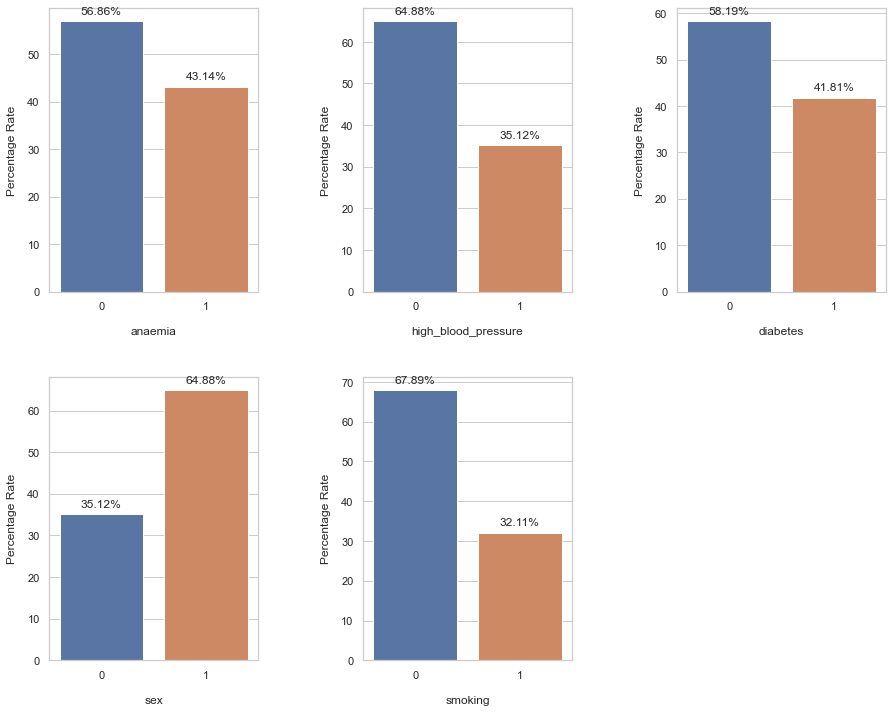

In [12]:
# Univariate Plot Analysis of Ordered categorical variables vs Percentage Rate
category_list = ['anaemia', 'high_blood_pressure', 'diabetes', 'sex', 'smoking']
counter = 1

plt.figure(figsize = (15, 12))

for col_list in category_list:
        
    series = round(((heart_faliure_data[col_list].value_counts(dropna = False))/
                    (len(heart_faliure_data[col_list])) * 100), 2)

    plt.subplot(2, 3, counter)
    ax = sns.barplot(x = series.index, y = series.values, order = series.sort_index().index)
    plt.xlabel(col_list, labelpad = 15)
    plt.ylabel('Percentage Rate', labelpad = 10)

    # Call Custom Function
    add_data_labels(ax)

    counter += 1

del category_list, counter, ax

plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.5)
plt.show()

###  Distribution of Age

In [13]:
colors = ['rgb(0, 0, 100)']

fig = ff.create_distplot(hist_data = [heart_faliure_data["age"].values], group_labels = ['age'], 
                         colors = colors, bin_size=2)

fig.update_layout(title_text='Distribution of Age')

fig.show()

###  Distribution of Age w.r.t Gender

In [14]:
fig = px.box(heart_faliure_data, x = 'sex', y = 'age', points = "all", hover_name = 'sex', 
             color = 'sex', notched=True)
fig.update_layout(title_text="Distribution of Age, Gender Wise - Male: 1, Female: 0")
fig.show()

In [15]:
survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["age"]
not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["age"]

In [16]:
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [survived, not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[1, 1], colors = colors)
fig.update_layout(title_text = "Effect of Age on the Survival Rate")

fig.show()

In [17]:
male = heart_faliure_data[heart_faliure_data["sex"] == 1]
female = heart_faliure_data[heart_faliure_data["sex"] == 0]

male_survived = male[heart_faliure_data["DEATH_EVENT"] == 0]
male_not_survived = male[heart_faliure_data["DEATH_EVENT"] == 1]
female_survived = female[heart_faliure_data["DEATH_EVENT"] == 0]
female_not_urvived = female[heart_faliure_data["DEATH_EVENT"] == 1]

In [19]:
hypertension_yes = heart_faliure_data[heart_faliure_data['high_blood_pressure']==1]
hypertension_no = heart_faliure_data[heart_faliure_data['high_blood_pressure']==0]

hypertension_yes_survived = hypertension_yes[heart_faliure_data["DEATH_EVENT"] == 0]
hypertension_yes_not_survived = hypertension_yes[heart_faliure_data["DEATH_EVENT"] == 1]
hypertension_no_survived = hypertension_no[heart_faliure_data["DEATH_EVENT"] == 0]
hypertension_no_not_survived = hypertension_no[heart_faliure_data["DEATH_EVENT"] == 1]

In [20]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=['Hypertension Distribution', 'Hypertension and Survival Rate'])

labels1 = ["Hypertension YES","Hypertension NO"]
values1 = [len(hypertension_yes), len(hypertension_no)]

labels2 = ['Hypertension YES - Survived','Hypertension  YES - Not Survived', 'Hypertension NO - Survived',
           'Hypertension  NO - Not Survived']
values2 = [len(hypertension_yes_survived), len(hypertension_yes_not_survived),
          len(hypertension_no_survived), len(hypertension_no_not_survived)]

# fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Hypertension"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Hypertension & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Hypertension Distribution and Survival Rate...")

fig.show()

In [21]:
diabetes_yes = heart_faliure_data[heart_faliure_data['diabetes']==1]
diabetes_no = heart_faliure_data[heart_faliure_data['diabetes']==0]

diabetes_yes_survived = diabetes_yes[heart_faliure_data["DEATH_EVENT"] == 0]
diabetes_yes_not_survived = diabetes_yes[heart_faliure_data["DEATH_EVENT"] == 1]
diabetes_no_survived = diabetes_no[heart_faliure_data["DEATH_EVENT"] == 0]
diabetes_no_not_survived = diabetes_no[heart_faliure_data["DEATH_EVENT"] == 1]

In [22]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Diabetes Distribution', 'Diabetes and Survival Rate'])

labels1 = ["Diabetes YES", "Diabetes NO"]
values1 = [len(diabetes_yes), len(diabetes_no)]

labels2 = ['Diabetes YES - Survived','Diabetes  YES - Not Survived', 'Diabetes NO - Survived',
           'Diabetes  NO - Not Survived']
values2 = [len(diabetes_yes_survived), len(diabetes_yes_not_survived),
          len(diabetes_no_survived), len(diabetes_no_not_survived)]

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Diabetes"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Diabetes & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Diabetes Distribution and Survival Rate...")

fig.show()

In [23]:
smoking_yes = heart_faliure_data[heart_faliure_data['smoking']==1]
smoking_no = heart_faliure_data[heart_faliure_data['smoking']==0]

smoking_yes_survived = smoking_yes[smoking_yes["DEATH_EVENT"] == 0]
smoking_yes_not_survived = smoking_yes[smoking_yes["DEATH_EVENT"] == 1]
smoking_no_survived = smoking_no[smoking_no["DEATH_EVENT"] == 0]
smoking_no_not_survived = smoking_no[smoking_no["DEATH_EVENT"] == 1]

In [25]:
anaemia_yes = heart_faliure_data[heart_faliure_data['anaemia']==1]
anaemia_no = heart_faliure_data[heart_faliure_data['anaemia']==0]

anaemia_yes_survived = anaemia_yes[anaemia_yes["DEATH_EVENT"] == 0]
anaemia_yes_not_survived = anaemia_yes[anaemia_yes["DEATH_EVENT"] == 1]
anaemia_no_survived = anaemia_no[anaemia_no["DEATH_EVENT"] == 0]
anaemia_no_not_survived = anaemia_no[anaemia_no["DEATH_EVENT"] == 1]

In [26]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Anaemia Distribution', 'Anaemia and Survival Rate'])

labels1 = ["Anaemia YES", "Anaemia NO"]
values1 = [len(anaemia_yes), len(anaemia_no)]

labels2 = ['Anaemia YES - Survived','Anaemia  YES - Not Survived', 'Anaemia NO - Survived',
           'Anaemia  NO - Not Survived']
values2 = [len(anaemia_yes_survived), len(anaemia_yes_not_survived),
          len(anaemia_no_survived), len(anaemia_no_not_survived)]

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Anaemia"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Anaemia & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Anaemia Distribution and Survival Rate...")

fig.show()

### Quantitative Variables

#### creatinine_phosphokinase

#### ejection_fraction

#### platelets

#### serum_creatinine

#### serum_sodium

In [27]:
# Distribution of the CPK enzyme levels in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "creatinine_phosphokinase", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Level of the CPK enzyme in the blood")

fig.show()

In [28]:
cpk_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["creatinine_phosphokinase"]
cpk_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["creatinine_phosphokinase"]

In [29]:
# Distribution of the CPK enzyme levels in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [cpk_survived, cpk_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[50, 50], colors = colors)
fig.update_layout(title_text = "Effect of CPK levels on the Survival Rate")

fig.show()

In [30]:
# Distribution of the Ejection Fraction in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "ejection_fraction", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Percentage of Blood leaving the left ventricle with each heartbeat...")

fig.show()

In [31]:
ef_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["ejection_fraction"]
ef_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["ejection_fraction"]

In [32]:
# Distribution of the Ejection Fraction in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [ef_survived, ef_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[2, 2], colors = colors)
fig.update_layout(title_text = "Effect of Ejection Fraction on Survival Rate incase of Heart Failure")

fig.show()

In [33]:
# Distribution of the Platelets in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "platelets", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Ptatelet Count Distribution and Survival Rate...")

fig.show()

In [34]:
platelet_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["platelets"]
platelet_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["platelets"]

In [35]:
# Distribution of the Platelets in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [platelet_survived, platelet_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[50, 50], colors = colors)
fig.update_layout(title_text = "Platelet Count v/s. Survival Rate")

fig.show()

In [36]:
# Notched box plots apply a "notch" or narrowing of the box around the median. 
# Notches are useful in offering a rough guide to significance of difference of medians; 
# if the notches of two boxes do not overlap, this offers evidence of a statistically significant 
# difference between the medians. Ref - https://en.wikipedia.org/wiki/Box_plot#Variations

fig = px.box(heart_faliure_data, x = 'DEATH_EVENT', y = 'platelets', points = "all", hover_name = 'DEATH_EVENT', 
             color = 'DEATH_EVENT', notched=True)

fig.update_layout(title_text="Distribution of Platelets w.r.t Survival Rate")

fig.show()

In [37]:
print("Elevated Serum Levels and Death Cases")
print("-------------------------------------------------------------")

# Total number of death cases and the levels of serum creatinine in such cases
death_events = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]
print("Total number of death cases reported due to heart failure:", death_events.shape[0])

# Higher levels of serum - the upper limit is chosen as 1.1 as per the texts and studies cited above.
high_serum_level_deaths = death_events[death_events["serum_creatinine"] >= 1]
print("Total number of death cases with much higher serum levels:", high_serum_level_deaths.shape[0])

print("\nElevated Serum Levels and Survival Cases")
print("-------------------------------------------------------------")

# Total number of survival cases and the levels of serum creatinine in such cases
survivals = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]
print("Total number of survivals after a heart failure condition:", survivals.shape[0])

# Higher levels of serum - the upper limit is chosen as 1.1 as per the texts and studies cited above.
high_serum_level_survivals = survivals[survivals["serum_creatinine"] >= 1]
print("Total number of survivals with higher serum levels:", high_serum_level_survivals.shape[0])

Elevated Serum Levels and Death Cases
-------------------------------------------------------------
Total number of death cases reported due to heart failure: 96
Total number of death cases with much higher serum levels: 87

Elevated Serum Levels and Survival Cases
-------------------------------------------------------------
Total number of survivals after a heart failure condition: 203
Total number of survivals with higher serum levels: 131


#### Lets see the elevated serum levels in pie charts

In [38]:
# create a temporary dataset to work on as we do not want to disturb the original dataset
temp = heart_faliure_data.copy()

In [39]:
# create a new binary column 'high_serum_level' to indicate if the serum levels are on the higher side
temp['high_serum_level'] = [1 if x >= 1 else 0 for x in temp['serum_creatinine']] 

# assing the values to the new column
temp_high_serum = temp[temp["high_serum_level"] == 1]
temp_low_serum = temp[temp["high_serum_level"] == 0]

# create the temporary high and low serum levels dataset onjects to work on
high_serum_survived = temp_high_serum[temp_high_serum["DEATH_EVENT"] == 0]
high_serum_not_survived = temp_high_serum[temp_high_serum["DEATH_EVENT"] == 1]

low_serum_survived = temp_low_serum[temp_low_serum["DEATH_EVENT"] == 0]
low_serum_not_survived = temp_low_serum[temp_low_serum["DEATH_EVENT"] == 1]

In [40]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Serum Level Distribution', 'Serum and Survival Rate'])

labels1 = ["High Serum YES", "High Serum NO"]
values1 = [len(temp_high_serum), len(temp_low_serum)]

labels2 = ['High Serum YES - Survived','High Serum  YES - Not Survived', 'High Serum NO - Survived',
           'High Serum  NO - Not Survived']
values2 = [len(high_serum_survived), len(high_serum_not_survived),
          len(low_serum_survived), len(low_serum_not_survived)]

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Serum Levels"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Serum Levels & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Blood Serum Levels and Survival Rate...")

fig.show()

In [41]:
# Distribution of the Platelets in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "serum_creatinine", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Distribution of Serum Creatinine Levels and Survival Rate...")

fig.show()

In [42]:
# total survived and death cases w.r.t overall serum levels
serum_creatinine_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["serum_creatinine"]
serum_creatinine_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["serum_creatinine"]

In [43]:
# Distribution of the serum_creatinine in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [serum_creatinine_survived, serum_creatinine_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[0.2, 0.2], colors = colors)
fig.update_layout(title_text = "Serum Creatinine Levels v/s. Survival Rate")

fig.show()

In [45]:
# Based on the above medical research findings, 
# let us look at the sodium levels in the data we have

print("Low Sodium Levels and Death Cases")
print("-------------------------------------------------------------")

# Total number of death cases and the levels of serum sodium in such cases
death_events = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]
print("Total number of death cases reported due to heart failure:", death_events.shape[0])

# Low levels of sodium - the lower limit is chosen as 136 as per the texts and studies cited above.
low_sodium_level_deaths = death_events[death_events["serum_sodium"] <= 136]
print("Total number of death cases with much lower sodium levels:", low_sodium_level_deaths.shape[0])

print("\nLow Sodium Levels and Survival Cases")
print("-------------------------------------------------------------")

# Total number of survival cases and the levels of serum sodium in such cases
survivals = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]
print("Total number of survivals after a heart failure condition:", survivals.shape[0])

# Low levels of sodium - the lower limit is chosen as 136 as per the texts and studies cited above.
low_sodium_level_survivals = survivals[survivals["serum_sodium"] <= 136]
print("Total number of survivals with lower sodium levels:", low_sodium_level_survivals.shape[0])

Low Sodium Levels and Death Cases
-------------------------------------------------------------
Total number of death cases reported due to heart failure: 96
Total number of death cases with much lower sodium levels: 59

Low Sodium Levels and Survival Cases
-------------------------------------------------------------
Total number of survivals after a heart failure condition: 203
Total number of survivals with lower sodium levels: 80


#### Lets see the serum sodium levels in pie charts

In [46]:
# create a new binary column 'low_sodium_level' to indicate if the 
# serum sodium levels are on the higher side
temp['low_sodium_level'] = [1 if x <= 136 else 0 for x in temp['serum_sodium']] 

# assing the values to the new column
temp_low_sodium = temp[temp["low_sodium_level"] == 1]
temp_acceptable_sodium = temp[temp["low_sodium_level"] == 0]

# create the temporary high and low serum levels dataset onjects to work on
low_sodium_survived = temp_low_sodium[temp_low_sodium["DEATH_EVENT"] == 0]
low_sodium_not_survived = temp_low_sodium[temp_low_sodium["DEATH_EVENT"] == 1]

acceptable_sodium_survived = temp_acceptable_sodium[temp_acceptable_sodium["DEATH_EVENT"] == 0]
acceptable_sodium_not_survived = temp_acceptable_sodium[temp_acceptable_sodium["DEATH_EVENT"] == 1]

In [47]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Sodium Level Distribution', 'Sodium and Survival Rate'])

labels1 = ["Low Sodium Level", "Acceptable Sodium Level"]
values1 = [len(temp_low_sodium), len(temp_acceptable_sodium)]

labels2 = ['Low Sodium - Survived','Low Sodium - Not Survived', 'Acceptable Sodium - Survived',
           'Acceptable Sodium - Not Survived']
values2 = [len(low_sodium_survived), len(low_sodium_not_survived),
          len(acceptable_sodium_survived), len(acceptable_sodium_not_survived)]

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Sodium Levels"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Sodium Levels & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Blood Serum Sodium Levels and Survival Rate...")

fig.show()

In [48]:
# Distribution of the Sodium in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "serum_sodium", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Distribution of Serum Sodium Levels and Survival Rate...")

fig.show()

In [49]:
# total survived and death cases w.r.t overall sodium level distribution

serum_sodium_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["serum_sodium"]
serum_sodium_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["serum_sodium"]

In [50]:
# Distribution of the serum_creatinine in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [serum_sodium_survived, serum_sodium_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[0.2, 0.2], colors = colors)
fig.update_layout(title_text = "Serum Sodium Levels v/s. Survival Rate")

fig.show()

###  Distribution of DEATH_EVENTS

Total Death Cases = 96
Total Survivals = 203
Proportion of Deaths to Survivals is 47.29%


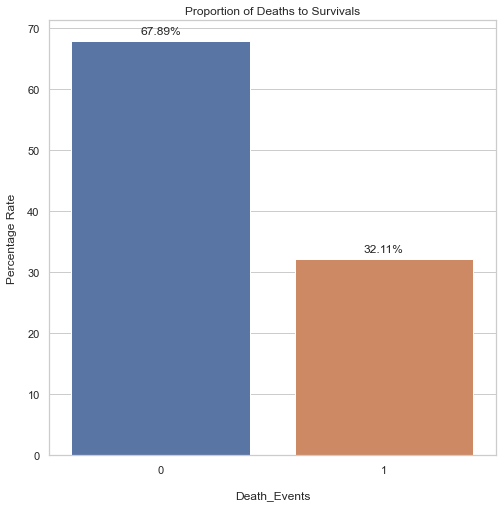

In [51]:
death_events = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1].shape[0]
survivals = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0].shape[0]

print(f"Total Death Cases = {death_events}")
print(f"Total Survivals = {survivals}")
print(f"Proportion of Deaths to Survivals is {(death_events / survivals) * 100:.2f}%")

plt.figure(figsize = (8, 8))

series = round(((heart_faliure_data["DEATH_EVENT"].value_counts(dropna = False))/
                (len(heart_faliure_data["DEATH_EVENT"])) * 100), 2)

ax = sns.barplot(x = series.index, y = series.values, order = series.sort_index().index)
plt.xlabel("Death_Events", labelpad = 15)
plt.ylabel('Percentage Rate', labelpad = 10)

# Call Custom Function
add_data_labels(ax)

plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.5)
plt.title("Proportion of Deaths to Survivals")
plt.show()

#### <font color = brown>Data Insight:</font>

**`1. In the population being studied for the condition of heart failure out of the 299 cases, 96 have succumbed to the condition while 203 cases survived.`**

**`2. In percentages, 32.11% of the cases succumbed (positive examples) while 67.89% cases survived (negative examples) the condition.`**

### Data Correlation

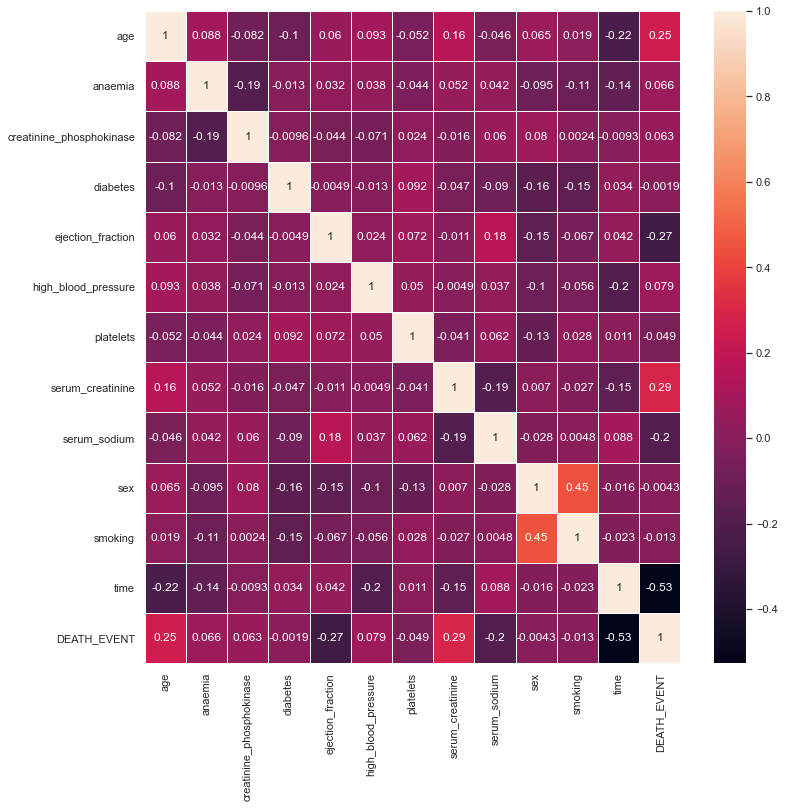

In [52]:
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(heart_faliure_data.corr(), annot = True, linewidths = .5, ax = ax)
plt.show()

In [53]:
feature_correlation_matrix = heart_faliure_data.corr()
feature_correlation_matrix[abs(feature_correlation_matrix['DEATH_EVENT']) > 0.1]['DEATH_EVENT']

age                  0.253729
ejection_fraction   -0.268603
serum_creatinine     0.294278
serum_sodium        -0.195204
time                -0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

#### <font color = brown>Data Insight:</font>

**`1. The Correlation matrix shows the correlation among the features and their correlation with the DEATH_EVENT.`**

**`2. Five features - 'age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'creatinine_phosphokinase', 'time' seem to be the most correlated to the death event when compared to the other features.`**

## Data Preparation

### Data Normalization

In [63]:
scaler = MinMaxScaler(feature_range=(0,100))

heart_faliure_data['platelets'] = scaler.fit_transform(heart_faliure_data[['platelets']])
heart_faliure_data['creatinine_phosphokinase'] = scaler.fit_transform(heart_faliure_data[['creatinine_phosphokinase']])

### Test - Train Split

In [64]:
# X = heart_faliure_data.drop('DEATH_EVENT', axis = 1)

# X = heart_faliure_data[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 
# 'creatinine_phosphokinase', 'time']]

# X = heart_faliure_data[['age', 'time','ejection_fraction','serum_creatinine', 'serum_sodium']] 

X = heart_faliure_data[['ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time', 'platelets']]

# X = heart_faliure_data[['time','ejection_fraction','serum_creatinine']]

# X = heart_faliure_data[['age','ejection_fraction','serum_sodium']]

y = heart_faliure_data[['DEATH_EVENT']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, test_size = 0.20, random_state = 100)

print("X_Train Shape:", X_train.shape)
print("Y_Train Shape:", y_train.shape)
print("X_Test Shape:", X_test.shape)
print("Y_Test Shape:", y_test.shape)

X_Train Shape: (239, 5)
Y_Train Shape: (239, 1)
X_Test Shape: (60, 5)
Y_Test Shape: (60, 1)


#### Data Value Counts

In [65]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))

Original dataset shape Counter({0: 164, 1: 75})



1. As we see in the training data, the number of 1s (80 - Death Event) are much less comapred to the number of 0s (174 - Survival Case). This is also confirmed in the Data UNBALANCE.


2. With this imbalance dataset (67.89% survival cases & 32.11% death events), the model could become more inclined towards learnign and predicting the negative examples than the positive (death) cases.

3. To avoid this scenario and create an un-biased model, the dataset should be balanced where we need to generate more  examples of the minority class. We will apply the Synthetic Minority Oversampling Technique (SMOTE) algorithm on the training data such that more examples of the death events are generated and we have a balanced dataset.


#### Synthetic Minority Oversampling Technique (SMOTE)

In [67]:
# Implement SMOTE
sampling = SMOTE(random_state = 100)
X_train_resampled, y_train_resampled = sampling.fit_resample(X_train.values, y_train.values.ravel())
    
# Shuffle the data
perms = np.random.permutation(X_train_resampled.shape[0])
X_train_resampled = X_train_resampled[perms]
y_train_resampled = y_train_resampled[perms]

X_train_resampled = pd.DataFrame(data = X_train_resampled)
y_train_resampled = pd.DataFrame(data = y_train_resampled)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

(328, 5)
(328, 1)


In [68]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))
print('Resampled dataset shape %s' % Counter(y_train_resampled.values.ravel()))
print('Test dataset shape %s' % Counter(y_test.values.ravel()))

Original dataset shape Counter({0: 164, 1: 75})
Resampled dataset shape Counter({1: 164, 0: 164})
Test dataset shape Counter({0: 39, 1: 21})


#### <font color = brown>Data Insight:</font>

**`1. With the application of SMOTE on the training data, the number of 1s (Death Event) are now equal to the number of 0s (Survival Case) with each 174 records/cases respectively.`**

## Reusable Utilities & Functions

In [69]:
# Custom Function to get Scores and plots...
def Generate_Model_Test_Classification_Report(model, X_test, y_test, model_name=""):

    '''
    Purpose: 
        Generate the consolidated test classification report. 
        The report consists of the following classification results & metrics -
            1. Confusion Matrix
            2. Classification Report
            3. F1 Score
            4. Accuracy
            5. Mathews Correlation Coefficient (MCC)
            6. Precision
            7. Recall
            8. AUROC Score - Area Under the Receiver Operating Characteristic Curve
            9. AUC-PR Score - Area Under the Precision Recall Curve.
            10. AUROC Curve - Area Under the Receiver Operating Characteristic Curve
            11. AUC-PR Curve - Area Under the Precision Recall Curve.

    Parameters:
        1. y_test - The Ground Truth for each test image.
        2. y_pred - The Predicted label for each image.
        3. model_name - Model Name

    Return Value: 
        NONE.
    '''

    # Report Title & Classification Mterics Abbreviations...
    fig, axes = plt.subplots(3, 1, figsize = (8, 3))
    axes[0].text(9, 1.8, "CONSOLIDATED MODEL TEST REPORT", fontsize=30, horizontalalignment='center', 
                 color='DarkBlue', weight = 'bold')

    axes[0].axis([0, 10, 0, 10])
    axes[0].axis('off')

    axes[1].text(9, 4, "Model Name: " + model_name, style='italic', 
                         fontsize=18, horizontalalignment='center', color='DarkOrange', weight = 'bold')

    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')

    axes[2].text(0, 4, "* 1 - Not Survived\t\t\t\t\t\t\t * 0 - Survived\n".expandtabs() +
                 "* MCC - Matthews Correlation Coefficient\t\t* AUC - Area Under The Curve\n".expandtabs() +
                 "* ROC - Receiver Operating Characteristics     " + 
                 "\t* AUROC - Area Under the Receiver Operating    Characteristics".expandtabs(), 
                 style='italic', fontsize=10, horizontalalignment='left', color='orangered')

    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')

    scores = []
    metrics = ['F1       ', 'MCC      ', 'Precision', 'Recall   ', 'Accuracy ',
               'AUC_ROC  ', 'AUC_PR   ']

    # Plot ROC and PR curves using all models and test data...
    y_pred = model.predict(X_test.values)
    y_pred_probs = model.predict_proba(X_test.values)[:, 1:]

    fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_pred)
    precision, recall, th = precision_recall_curve(y_test.values.ravel(), y_pred_probs)

    # Calculate the individual classification metic scores...
    model_f1_score = f1_score(y_test, y_pred)
    model_matthews_corrcoef_score = matthews_corrcoef(y_test, y_pred)
    model_precision_score = precision_score(y_test, y_pred)
    model_recall_score = recall_score(y_test, y_pred)
    model_accuracy_score = accuracy_score(y_test, y_pred)
    model_auc_roc = auc(fpr, tpr)
    model_auc_pr = auc(recall, precision)

    scores.append([model_f1_score,
                   model_matthews_corrcoef_score,
                   model_precision_score,
                   model_recall_score,
                   model_accuracy_score,
                   model_auc_roc,
                   model_auc_pr])

    sampling_results = pd.DataFrame(columns = ['Classification Metric', 'Score Value'])
    for i in range(len(scores[0])):
        sampling_results.loc[i] = [metrics[i], scores[0][i]]

    sampling_results.index = np.arange(1, len(sampling_results) + 1)

    class_report = classification_report(y_test, y_pred)
    conf_matx = confusion_matrix(y_test, y_pred)

    # Display the Confusion Matrix...
    fig, axes = plt.subplots(1, 3, figsize = (20, 4))
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16},fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
    axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight = 'bold', 
                      style='italic', loc='left', y=0.80)

    # Classification Metrics
    axes[1].text(5, 1.8, sampling_results.to_string(float_format='{:,.4f}'.format, index=False), style='italic', 
                 fontsize=20, horizontalalignment='center')
    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')
    axes[1].set_title("2. Classification Metrics", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center', y=0.80)

    # Classification Report
    axes[2].text(0, 1, class_report, style='italic', fontsize=20)
    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')
    axes[2].set_title("3. Classification Report", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center', y=0.80)

    plt.tight_layout()
    plt.show()

    # AUC-ROC & Precision-Recall Curve
    fig, axes = plt.subplots(1, 2, figsize = (14, 4))

    axes[0].plot(fpr, tpr, label = f"auc_roc = {model_auc_roc:.3f}")
    axes[1].plot(recall, precision, label = f"auc_pr = {model_auc_pr:.3f}")

    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].legend(loc = "lower right")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("4. AUC - ROC Curve", fontsize=15, color='darkgreen', ha='right', weight = 'bold', 
                      style='italic', loc='center', pad=1, y=1.05)

    axes[1].legend(loc = "lower left")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("5. Precision - Recall Curve", fontsize=15, color='darkgreen', ha='right', weight = 'bold', 
                      style='italic', loc='center', pad=3, y=1.05)

    plt.subplots_adjust(top=0.95) 
    plt.tight_layout()
    plt.show()
    
##########################################################################################################################
    
def plot_model_feature_importances(model):
    '''
    Custom function to plot the 
    feature importances of the classifier.
    '''
    fig = plt.figure()
    
    # get the feature importance of the classifier 'model'
    feature_importances = pd.Series(model.feature_importances_,
                            index = X_train.columns) \
                    .sort_values(ascending=False)
    
    # plot the bar chart
    sns.barplot(x = feature_importances, y = X_train.columns)
    plt.title('Classifier Feature Importance', fontdict = {'fontsize' : 20})
    plt.xticks(rotation = 60)
    plt.show()

## Model Building & Training

To predict patients survival due to heart failure, we will train models from different machine learning algorithms. The classifiers to be used in this study will be -

**`1. Support Vector Machines with RBF kernel`**

**`2. Decision Tree`**

**`3. Random Forest`**

All models are evaluated considering the following metrics

* ${accuracy = \frac {TP+TN}{TP+TN+FP+FN}\quad }$


* ${precision = \frac {TP}{TP+FP}\quad}$


* ${recall = \frac {TP}{TP+FN}\quad}$ 


* ${F_1 = 2 \times \frac{precision \times recall}{precision+recall}



<a id='Support_vector_machine'></a>
## 1.Support Vector Machine <a style="text-decoration:none" href="#Classification_models">⤴</a>

Support vector machine is a powerful model used for both classification and regression.<br>
It consists in trying to fit an hyperplane that best divides the dataset into the two classes by maximizing the margin (the distance between the hyperplane and the closest points).


#### Hard margin
The simplest implementation is the hard margin SVM in which data needs to be linearly separable to allow the algorithm to converge.<br>
Considering the hyperplane described by the vector **w** such that:<br>

\begin{align}
{L=\{v:\langle w,v\rangle+ b= 0\}}\space , \space ‖w‖=1
\end{align}

the distance of a point fom the hyperplane L can be evaluated in that way:<br>

\begin{align}
{d(x,L) =| \langle w,x \rangle+ b |}
\end{align}

while the distance between two points of two different classes on the margin is:

\begin{align}
\frac{<x_{+} - x_{-}, W>}{\left \| W \right \|} = \frac{(<x_{+}, W> + \space b) - (<x_{-}, W> + \space b)}{\left \| W \right \|} = \frac{2}{\left \| W \right \|}
\end{align}

So we need to find w and b such that that distance is **maximized** (considering the whole training set) and at the same time all the points are **classified correctly**.<br>
Equivalently:<br>

\begin{align}
{min_{w,b} \frac{1}{2}‖w‖^2 \space\space s.t. \space\space \forall i,\space\space y_i \big(\langle w,x_i\rangle+b \big)>1}
\end{align}

where $y_i$ is the true label and the prediction is the evaluated distance of the sample from the hyperplane.
Basically if the label and the prediction have the same sign it means that the prediction is on the correct side of the margin.<br>
When the algorithm has converged, then the model can be described using only the points on the margin (called **support vectors**). This means that SVM can scale well.<br>
Being able to respect this constraint means having a linearly separable problem.<br>
The main drawback is that, in the real world, the vast majority of the problems are not linearly separable, and an algorithm like this one would not converge.<br>
For this reason we can add a term on the constraints to relax them.

#### Soft margin
In this implementation, a 
<span style="color:red">relaxation</span>
is added to the constraint.<br>

\begin{align}
{
min_{w,b} \Big(\frac{1}{2} ‖W‖^2 + {\color{red} {C  \sum_{i=1}^{m} {\xi_i}}}\Big)
\space \space
s.t.
\space \space
\forall i,\space\space y_i \big(\langle w,x_i\rangle+b \big)≥ 1 \color{red}{−\xi_i\space\space and \space\space \xi_i≥0}
} 
\end{align}

$\xi_i$ is called **slack variable**, it is the distance of $x_i$ from the corresponding class's margin if $x_i$ is on the wrong side of the margin and 0 otherwise.<br>
Smaller values of C allows more errors in exchange of a bigger margin, while higher values can be used where it's needed to be less permissive regarding misclassificatons, with an higher risk of overfitting.

In some cases, problems are not well separable on the original feature space but they are separable on another space.<br>
Therefore it's possible to map our features in another higher dimensional space in which hopefully it will be easier to learn.<br>
One simple example is the polynomial mapping:<br>

A degree k polynomial is 
$p(x)=\sum_{j=0}^{k}w_jx^j\space$

that can also be seen as:
$\space \langle w,\psi(x)\rangle \space \space where \space \space \psi(x) = (1,x,x^2,...,x^k)$<br>

$\psi(x)$ is the polynomial mapping function

The problems arise in the case of multiple predictors.<br>
In fact in a polynomial mapping on a $\rm I\!R^2$ space:

$ \psi(\textbf{x}) = (x_1^2, x_2^2, \sqrt2x_1x_2)$ <br>
(considering only the quadratic features)

This means that, in the cases in which there are a lot of features, mapping every time from the original to the new space could be costly (second order features in 1000 dimensions are around $5\cdot10^5$ numbers)<br>
The solution is using kernel functions.<br>

#### Kernel trick
To solve the svm optimization problem, computing inner products it's needed.<br>
In fact, according to **representer theorem**, $w$ can be written as:

${w = \sum_{i} \alpha_i\psi(x_i)}\space$

so it follows that: <br>

$\space ‖w‖^2 = \langle \sum_j{\alpha_j\psi(x_j)}, \sum_j{\alpha_j\psi(x_j)}\rangle = \sum_{i,j=1}^{m}\alpha_i\alpha_j\langle\psi(x_i),\psi(x_j)\rangle $

and the problem now consists in minimizing the margin over $\alpha$.<br>
Once $\alpha$ vector is obtained, **support vectors** correspond to samples that have an alpha value that is greater than zero (so to describe the model, only those samples are needed).

Considering the mapping, this operation could be unfeasible.<br>
A **kernel function** is a function that implements the inner product in the new feature space (given $\psi$):<br>

${ K(\textbf{x},\textbf{x}^\prime) =\langle\psi(\textbf{x}),\psi(\textbf{x}^\prime)\rangle}$

In this way we don't have to explicitly apply ${\psi}$ on our data and then compute the inner product.<br>

A symmetric function $K: X\times X \rightarrow \rm I\!R$ can be a kernel function if and only if it respects the **Mercer theorem** that says that the Gram matrix, that is the matrix such that:
${G_{i,j} = K (\textbf{x}_i, \textbf{x}_j)}$ needs to be **positive semidefinite**.

A matrix is semidefinite if and only if:

${\textbf{x}^T G \textbf{x} > 0\space \space\forall \textbf{x}\in R^n \backslash 0}$<br>
and the aigenvalues are **non-negative**.

<br><br>
The most used kernels are:
* the **polynomial kernel** (degree k)<br>
${(\langle \textbf{x}, \textbf{x}^\prime \rangle + 1)^k }$


* the **radial basis function** (gaussian kernel)<br>
${e^{-\gamma ‖\textbf{x} - \textbf{x}^\prime‖^2}}$

Linear kernel means that no mapping is done and the kernel is simply ${\langle \textbf{x}, \textbf{x}^\prime\rangle}$

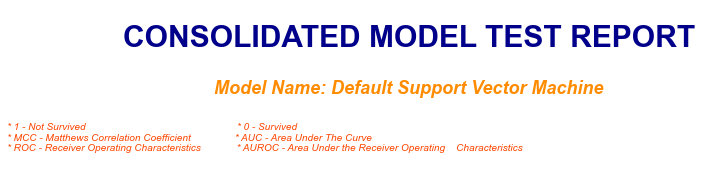

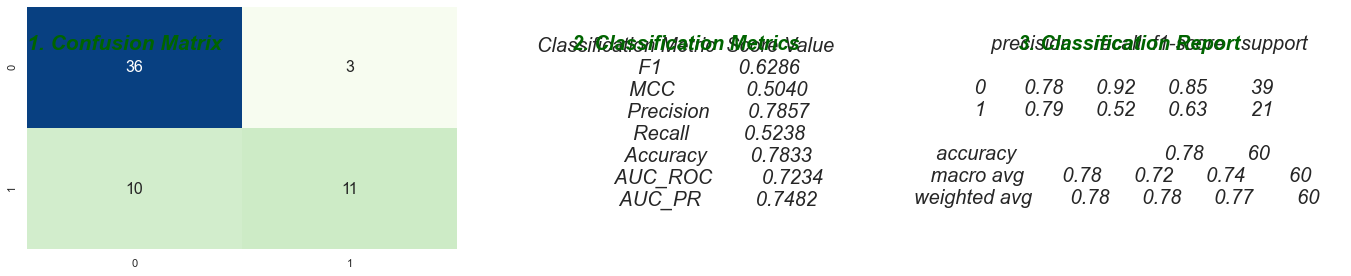

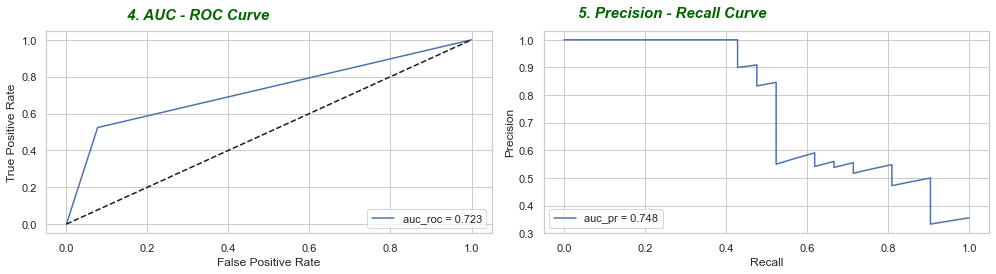

In [70]:
# SVM with Default Parameters and probability = True

svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

svm = svm.fit(X_train_resampled.values, y_train_resampled.values.ravel())


# Generate the model test classification report
Generate_Model_Test_Classification_Report(svm, X_test, y_test, model_name="Default Support Vector Machine")

#### SVM Hyperparameters Tuning

In [71]:
# GridSearchCV to find best parameters for svm
svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

# parameters to build the model on
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}  

grid_search = GridSearchCV(estimator = svm, param_grid = param_grid, 
                  scoring = 'accuracy', n_jobs = -1, cv = 5, verbose = 2)

# fitting the model for grid search 
grid_search.fit(X_train_resampled.values, y_train_resampled.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", grid_search.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", grid_search.best_estimator_) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'C': 1, 'gamma': 0.01}

Best Classifier: SVC(C=1, gamma=0.01, probability=True, random_state=100)


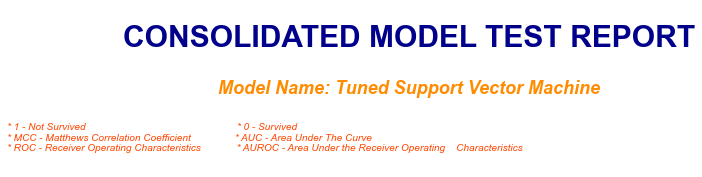

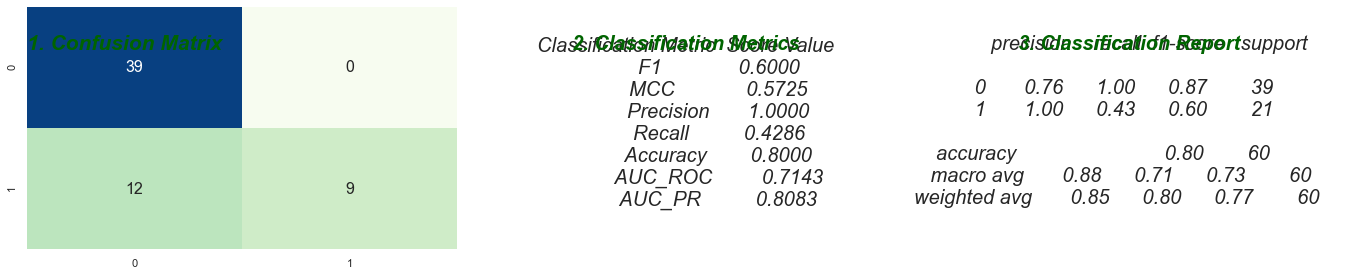

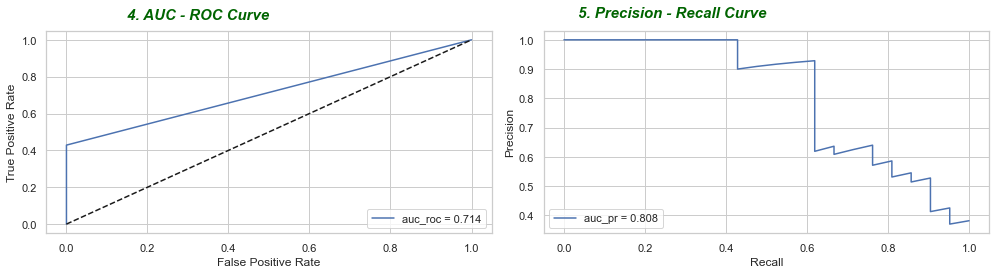

In [72]:
best_svc = grid_search.best_estimator_

best_svc.fit(X_train_resampled.values, y_train_resampled.values.ravel())


# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_svc, X_test, y_test, model_name="Tuned Support Vector Machine")

<a id='Decision_tree'></a>
## 2.Decision tree <a style="text-decoration:none" href="#Classification_models">⤴</a>

Decision trees are one of the most widely known machine learning models.<br>
They are non-parametric models that learn by recursively split the predictor space (and so the train samples) according to the **best** feature (greedy approach) until the tree reaches a constrained depth, the subsets contain elements of only one class or it meets another stopping criterion (e.g. less than 5 samples in the subset).<br>
The **best** feature is the feature that, if used to discriminate samples, allows us to obtain the best possible split according to a measure.<br>
Such measure in this case is the **Gini Index** (in this sklearn implementation the unnormalized gini index is used)<br>

${G = 1-\sum_{j} p_j^2}$  
where $p$ is the ratio between number of samples of class $j$ and total number of samples.

Gini index is evaluated on both the splits, weighted by the number of samples in each split and the feature that gives us the lower overall Gini index is chosen.<br>

Due to the nature of this model, the explainability is quite high. Is in fact possible to plot the tree to see how the dataset is split at every step and it's easy to describe how the prediction works.<br>
The main drawback of decision tree is the fact that sometimes is a too simple model, that provides lower values of accuracy and it's easy to overfit.<br>
To tackle this problem it's possible to train an *ensemble* of decision trees, called **random forest**.

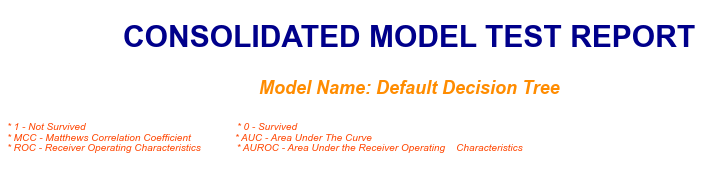

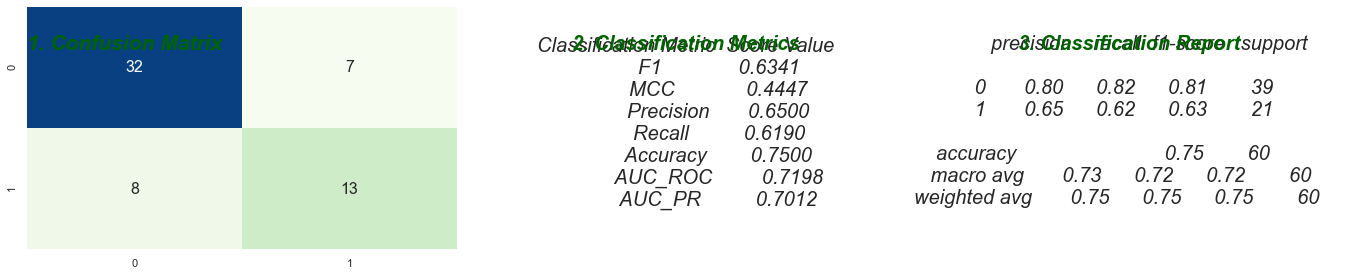

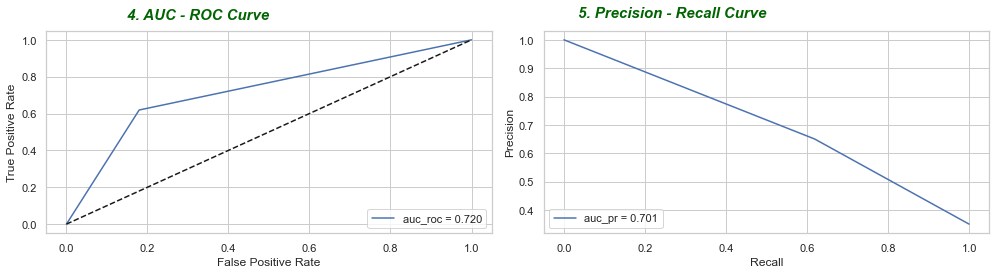

In [73]:
# Decision Tree with Default Parameters

tree = DecisionTreeClassifier(random_state = 100)

tree = tree.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(tree, X_test, y_test, model_name="Default Decision Tree")

#### Decision Tree Hyperparameters Tuning

In [74]:
# GridSearchCV to find the optimal tree parameters
tree = DecisionTreeClassifier(random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 30), 
              "max_features": randint(1, 9), 
              "min_samples_leaf": randint(1, 9),
              "min_samples_split":range(2, 10),
              "criterion": ["gini", "entropy"]}

# Instantiating RandomizedSearchCV object 
tree_grid = RandomizedSearchCV(tree, param_grid, cv = 5) 
    
# fitting the model for grid search 
tree_grid.fit(X_train_resampled.values, y_train_resampled.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", tree_grid.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", tree_grid.best_estimator_) 

Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 7}

Best Classifier: DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features=1,
                       min_samples_leaf=2, min_samples_split=7,
                       random_state=100)


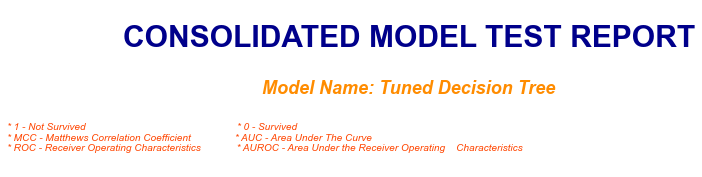

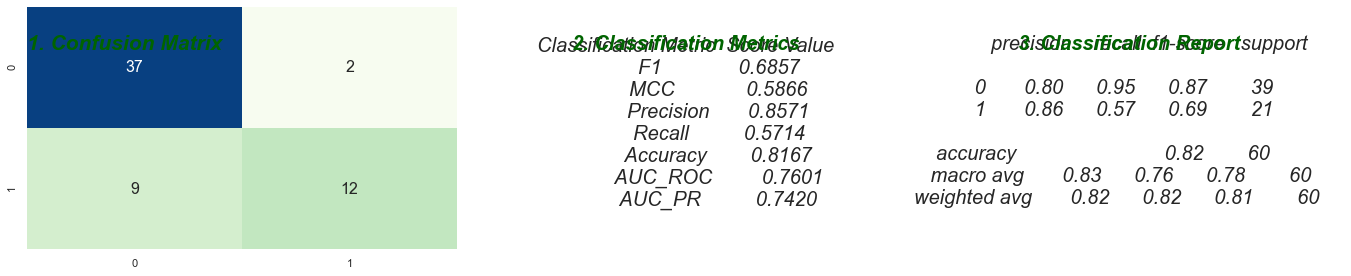

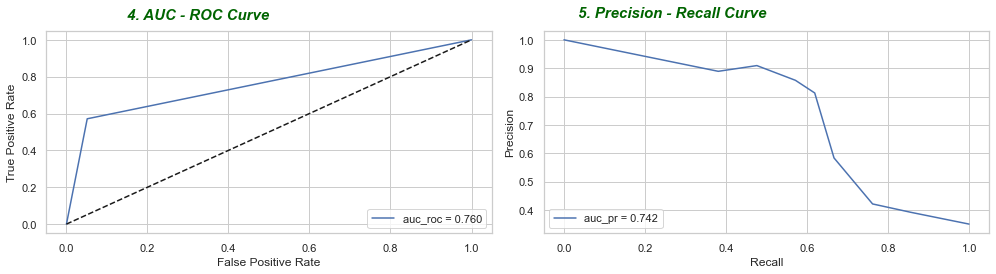

In [76]:
best_tree = tree_grid.best_estimator_

best_tree = best_tree.fit(X_train.values, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_tree, X_test, y_test, model_name="Tuned Decision Tree")

<a id='Random_forest'></a>
## Random forest <a style="text-decoration:none" href="#Classification_models">⤴</a>

Random forest is an ensemble model based on a number of decision trees.<br>
The decision trees are trained with data, sampled **with repetition** from the original dataset (bagging).<br>
**Bootstrapping** training data in fact allow us to decrease the variance of the model without increasing the bias (average of many trees is less sensitive to noise with respect to single tree) and helps us to train trees that are less correlated.<br>
(Each tree will be trained on average on 63.2% of training data)<br>
**Feature bagging** is also performed: this means that at each candidate split, only a subset of features (traditionally the square root or the log2 of the total number) is considered.<br>
This forces the models to select different features, increasing uncorrelation.<br>
Prediction is then done by majority voting.

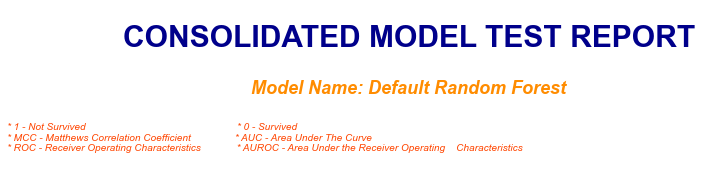

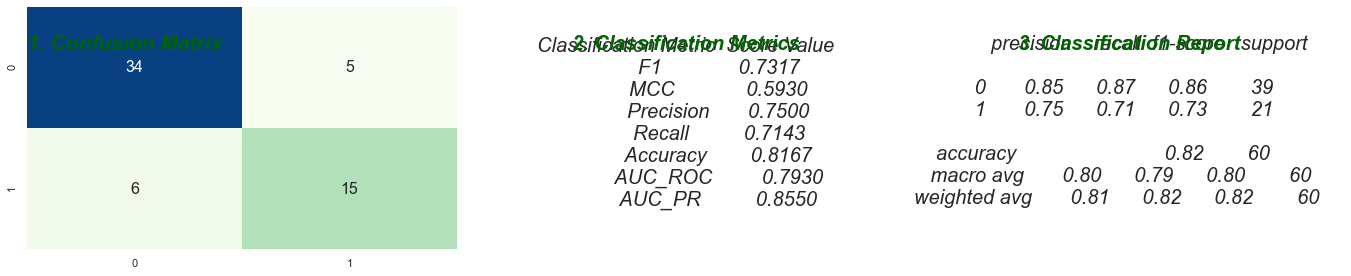

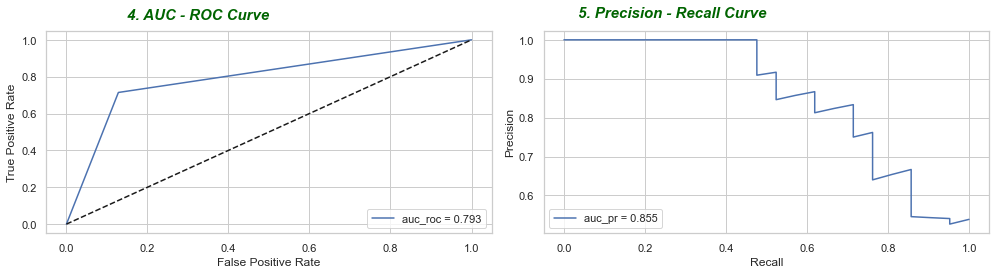

In [77]:
# Random Forest with Default Parameters
rfc = RandomForestClassifier(n_jobs = -1, random_state = 100)

rfc = rfc.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(rfc, X_test, y_test, model_name="Default Random Forest")

#### Random Forest Hyperparameters Tuning

In [78]:
rn_forest = RandomForestClassifier(n_jobs = -1, random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 10), 
              "max_features": randint(1, 20), 
              "min_samples_leaf": randint(25, 50),
              "min_samples_split":range(50, 100, 2),
              "n_estimators": range(1000, 8000, 500),
              "bootstrap": [True, False]}

# Instantiating RandomizedSearchCV object 
forest_grid = RandomizedSearchCV(rn_forest, param_grid, cv = 5) 
    
# fitting the model for grid search 
forest_grid.fit(X_train_resampled.values, y_train_resampled.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", forest_grid.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", forest_grid.best_estimator_) 

Best Parameters: {'bootstrap': False, 'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 36, 'min_samples_split': 74, 'n_estimators': 6500}

Best Classifier: RandomForestClassifier(bootstrap=False, max_depth=9, max_features=5,
                       min_samples_leaf=36, min_samples_split=74,
                       n_estimators=6500, n_jobs=-1, random_state=100)


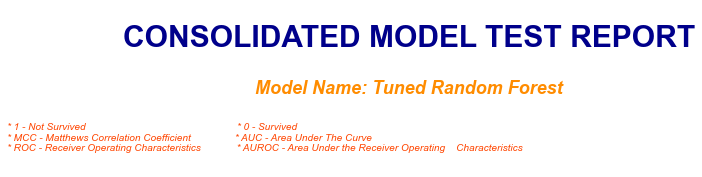

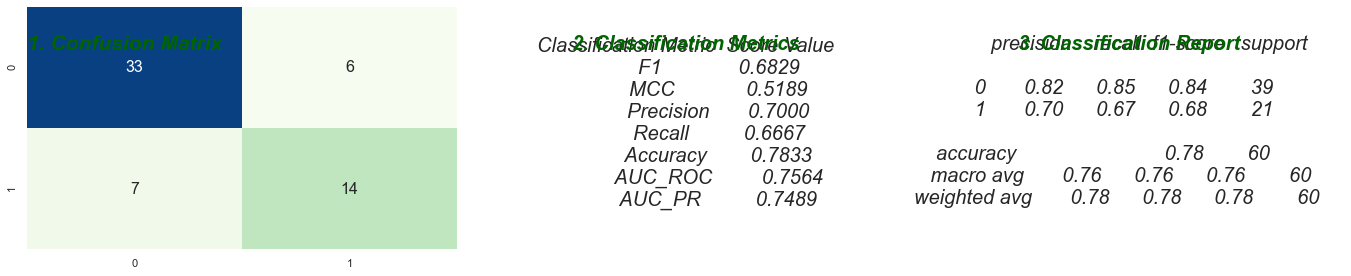

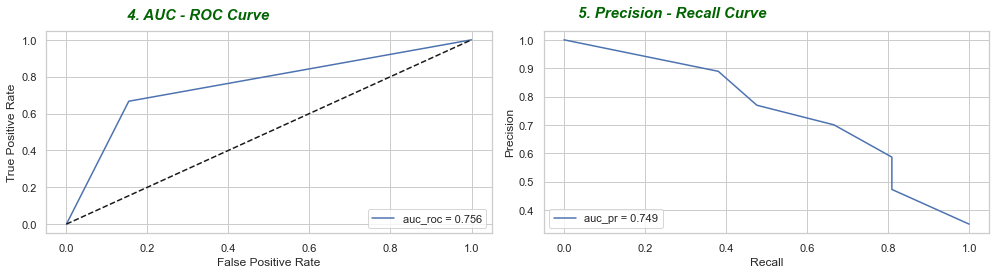

In [81]:
# Random Forest with Best Hypertuned Parameters
best_forest = forest_grid.best_estimator_

best_forest = best_forest.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_forest, X_test, y_test, model_name="Tuned Random Forest")

**`The above chart shows the impact of the features on the model's output for each class.`**

# Inferences

**`1. 'age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time' seem to be the features that are more closely related to the death event.`**

**`2. The event of a heart failure in the old age could be fatal.`**

**`3. The levels of 'ejection_fraction', 'serum_creatinine', 'serum_sodium' play an important role in the event of heart failure or the abnormalities in the levels of these become an important factor in triggerring heart failure condition.`**
 
**`4. Machine Learning models can prove to be a time saving factor in predicting the event of death and can help the doctors take additional precauionary measures with critical care.`**

**`5. The imbalance in the dataset had been dealt using the SMOTE oversampling of the minority class. SMOTE balanced the no. of instances for each class but the amount of data is still limited.`**

**`6. The accuracy and model performance can be increased if more data is made available for the model to train on. This data limitation, limits the model performance to some extent. As more and more data becomes available, the prediction accuracy and model's ability to act on other similar real-time data could be enhanced.`**

# References
 
Machine learning can predict survival of patients with heart failure from serum creatinine and 
ejection fraction alone. (03 February 2020) https://doi.org/10.1186/s12911-020-1023-5